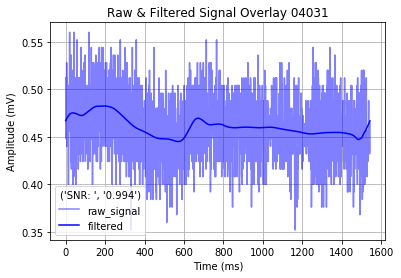

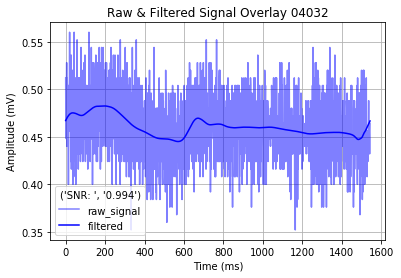

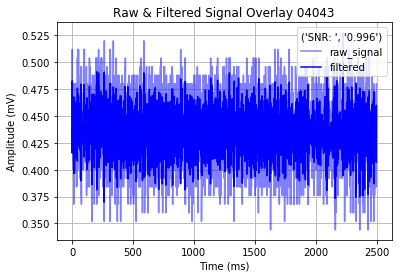

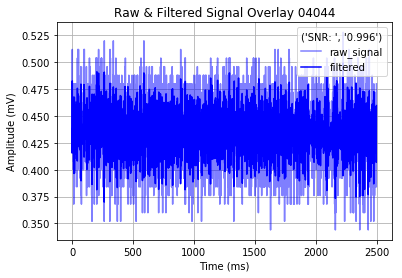

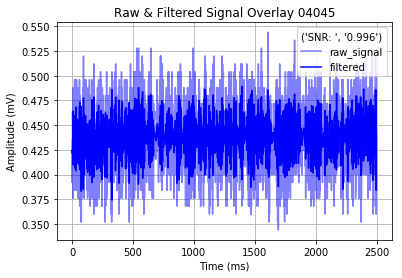

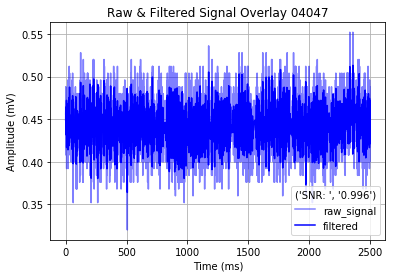

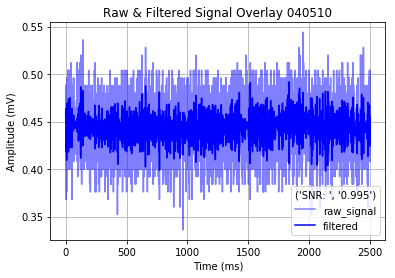

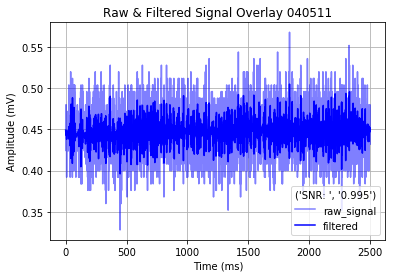

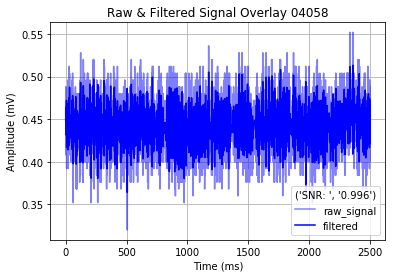

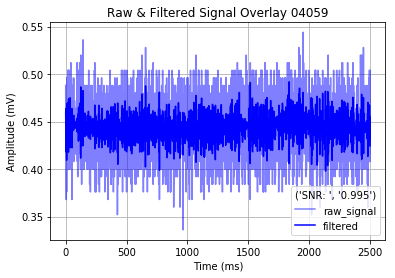

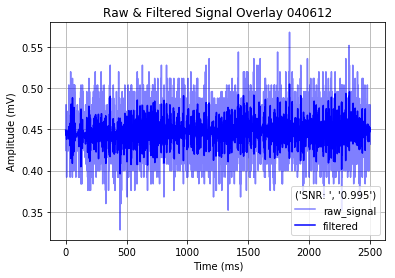

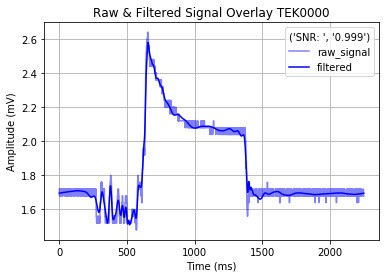

In [40]:
%matplotlib inline
#Discriminate wavelet reduction of motion noise
#Authored by: Connor Johnson
#Last modified: 2/28/2017 by Anna

# file processing
import os, ast
# signal processing
import pywt
import numpy as np
# visualization
import matplotlib.pyplot as plt

# Depreciated because I didn't want to install fortran and a whole library for one line of code
#from statsmodels.robust import mad

def mad(data, axis=None):
    # Authored by Anna
    # median absolute deviation
    return np.median(np.absolute(data - np.median(data,axis)), axis)

def waveletSmooth(signal, wavelet, level=1):
    # returns y a rectified and smoothed signal
    
    # multilevel wavelet decomposition generates coefficients
    coeff = pywt.wavedec(signal, wavelet, mode="per") #by default last axis is used
    # calc a threshold to exclude outliers beyond one median absolute deviation of gaussian
    sigma = mad(coeff[-level])
    signal_len = len(signal)
    threshold = sigma * np.sqrt(2*np.log(signal_len))
    coeff[1:] =(pywt.threshold(i , value=threshold, mode="soft") for i in coeff[1:])
    #reconstruct signal
    y = pywt.waverec(coeff, wavelet, mode="per")
    return y
    
def signal_to_noise(raw, filt):
    # returns the signal to noise given  raw amplitude and filtered amplitude
    
    # Frobenius normalization includes baseline difference
    signal = np.linalg.norm(filt)/len(filt)
    noise = np.linalg.norm(raw)/len(raw)
        
    if noise == 0:
        SNR = float('nan')
    else:
        SNR = (signal/noise)**2
    return SNR
    
    
raw_signal_path = """raw_signal/"""

for filename in os.listdir(raw_signal_path):
        signal = []
        if (not filename.endswith('.ipynb_checkpoints')):
            
            # fetch signal from file
            with open(raw_signal_path + filename) as fin:
                signal = ast.literal_eval(fin.read())
                
                # format list of tuples (time, amplitude) as numpy array
                dt=np.dtype('float,float')
                signal = np.array(signal, dtype=dt)
                                
                raw = [amplitude[1] for amplitude in signal]

            fin.close()
            
            # Eight part gaussian wavelet decomposition on amplitudes
            # f(t) = y(t) + e(t), where y(t) is the signal and e(t) is the noise
            wavelet_type = 'db8' # Daubechies wavelet mapping
            # smoothing level maxes out at 7
            filt = waveletSmooth(raw, wavelet_type, level=7)
            SNR = signal_to_noise(raw,filt)
           
            # visualize
            p1, = plt.plot(raw, color="b", alpha=0.5, label='raw_signal')
            p2, = plt.plot(filt, color="b", label='filtered')
            SNR_report = ('SNR: ', '%.3f'%(SNR))
            plt.legend([p1, p2], ['raw_signal', 'filtered'], loc=0, title=SNR_report)
            plt.title('Raw & Filtered Signal Overlay ' + filename )
            plt.xlabel('Time (ms)')
            plt.ylabel('Amplitude (mV)')
            plt.grid()
            plt.show()